In [1]:
import os
import pickle
import sys
import h5py
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

# os.chdir('codes')
import models
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
%matplotlib inline

prepare data

In [2]:
# CHOOSE THE AUGMENTS IF NECESSARY
device = 'cuda:4' # device where you put your data and models
data_path = './' # the path of the 'npc_v4_data.h5' file
batch_size = 50 # the batch size of the data loader
insp_layer = 'conv3' # the middle layer extracted from alexnet, available in {'conv1', 'conv2', 'conv3', 'conv4', 'conv5'}

"""
The file npc_v4_data.h5 is structured in the following way:
images: a tensor of shape [num_images, width, height, num_colors]
neural data: a tensor of shape [num_repetitions, num_images, num_neurons]
target indices: a list containing the indices of target neurons in data tensor
For some animals the data is collected within two sessions that are indicated by session_x
"""

with h5py.File(os.path.join(data_path, 'npc_v4_data.h5')) as hf:
    images_n = np.array(hf['images']['naturalistic'])
    neural_n = np.array(hf['neural']['naturalistic']['monkey_m']['stretch']['session_2'])

n_images = neural_n.shape[1]
n_neurons = neural_n.shape[2]
size_imags = images_n.shape[0]

reps = neural_n.shape[0]
rand_ind = np.arange(reps)
np.random.shuffle(rand_ind)

data_y_train = neural_n[:,:576].mean(0).astype(np.float32)
data_y_val_origin = neural_n[:, 576:].astype(np.float32)
data_y_val = data_y_val_origin.mean(0)


data_x = images_n[:, np.newaxis].astype(np.float32)
data_x = data_x / 255
data_x = np.tile(data_x, [1, 3, 1, 1])

data_x_train = data_x[:576]
data_x_val = data_x[576:]


class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y
    def __getitem__(self, index):
        return self.data_x[index], self.data_y[index]
    def __len__(self):
        return self.data_x.shape[0]

imagenet_mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32).view(1, 3, 1, 1).to(device)
imagenet_std =torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32).view(1, 3, 1, 1).to(device)
transform = lambda x : (x - imagenet_mean) / imagenet_std

dataset_train = Dataset(data_x_train, data_y_train)
dataset_val = Dataset(data_x_val, data_y_val)

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size)

# Problem (a)

In [3]:
()

()

In [32]:
# CHOOSE THE AUGMENTS IF NECESSARY
lamd_s, lamd_d = [3e-3, 1e-3] # the coefficients of the losses. Try other coefficients!
epoches = 50 # total epochs for training the encoder
lr = 1e-3 # the learing rate for training the encoder

alexnet = models.alexnet(pretrained=True)
alexnet.to(device)
alexnet.eval()
for param in alexnet.parameters():
    param.requires_grad_(False)

x = torch.from_numpy(data_x[0:1]).to(device)
fmap = alexnet(x, layer=insp_layer)

neurons = data_y_train.shape[1]
sizes = fmap.shape[2:]
channels = fmap.shape[1]


class conv_encoder(nn.Module):

    def __init__(self, neurons, sizes, channels):
        super(conv_encoder, self).__init__()
        # PUT YOUR CODES HERE
        self.W_s = nn.Parameter(torch.randn(size=(neurons,) + sizes))
        self.W_d = nn.Parameter(torch.randn(size = (neurons,channels,1,1)))
        self.W_b = nn.Parameter(torch.randn(size = (1,neurons)))


    def forward(self, x):
        # PUT YOUR CODES HERE
        out = torch.einsum('bchw , nhw -> bnchw',x,self.W_s) # dimension : N,n,C,h,w
        out = torch.stack(
            [F.conv2d(out[:,n,:,:,:],torch.unsqueeze(self.W_d[n],0)) for n in range(neurons)],dim=1) 
            #dimension:N,n,1,h,w
        out = torch.sum(out,dim=(2,3,4))
        out = out + self.W_b
        return out

def L_e(y,pred):
    return torch.mean(torch.sqrt(torch.sum((y-pred)**2,dim=1)))

def L_2(W_s,W_d,lamd_s=lamd_s,lamd_d=lamd_d):
    return lamd_s * torch.sum(W_s**2) + lamd_d * torch.sum(W_d**2)

K = torch.tensor([
    [0,-1,0],
    [-1,4,-1],
    [0,-1,0]],dtype=torch.float).to(device)
def L_laplace(W_s,lamd_s=lamd_s):
    return lamd_s * torch.sum(F.conv2d(torch.unsqueeze(W_s,1),K.unsqueeze(0).unsqueeze(0))**2)


# encoder = conv_encoder(neurons, sizes, channels).to(device)

def train_model(encoder, optimizer):
    losses = []
    encoder.train()
    for i,(x,y) in enumerate(loader_train):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        x = transform(x)
        fmap = alexnet(x,layer = insp_layer)
        out = encoder(fmap)
        l_e = L_e(y,out)
        l_2 = L_2(encoder.W_s,encoder.W_d)
        l_l = L_laplace(encoder.W_s)
#         print(f'L_e = {l_e} , L_2 = {l_2} , L_l = {l_l}')
        loss = L_e(y,out) + L_2(encoder.W_s,encoder.W_d) + L_laplace(encoder.W_s)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
#         print(f'iteration {i}, train loss: {losses[-1]}')
    
    return losses

def validate_model(encoder):
    encoder.eval()
    y_pred = []
    y_true = []
    losses = []
    for i,(x,y) in enumerate(loader_val):
        x = x.to(device)
        y = y.to(device)
        x = transform(x)
        fmap = alexnet(x,layer = insp_layer)
        out = encoder(fmap)
        y_pred.append(out)
        y_true.append(y)
        l_e = L_e(y,out)
        l_2 = L_2(encoder.W_s,encoder.W_d)
        l_l = L_laplace(encoder.W_s)
        print(f'L_e = {l_e} , L_2 = {l_2} , L_l = {l_l}')
        loss = L_e(y,out) + L_2(encoder.W_s,encoder.W_d) + L_laplace(encoder.W_s)
        losses.append(loss.item())
    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)
    explained_variance = metrics.explained_variance_score(y_true = y_true.detach().cpu().numpy(),y_pred = y_pred.detach().cpu().numpy())
    return explained_variance,sum(losses)/len(losses)

"""
    You need to define the conv_encoder() class and train the encoder.
    The code of alexnet has been slightly modified from the torchvision, for convenience
    of extracting the middle layers.
    
    Example:
        >>> x = x.to(device) # x is a batch of images
        >>> x = transform(x)
        >>> fmap = alexnet(x, layer=insp_layer)
        >>> out= encoder(fmap)
        >>> ...
"""



'\n    You need to define the conv_encoder() class and train the encoder.\n    The code of alexnet has been slightly modified from the torchvision, for convenience\n    of extracting the middle layers.\n    \n    Example:\n        >>> x = x.to(device) # x is a batch of images\n        >>> x = transform(x)\n        >>> fmap = alexnet(x, layer=insp_layer)\n        >>> out= encoder(fmap)\n        >>> ...\n'

In [ ]:
# losses_train = []
# losses_val = []
# EVs = []

In [39]:

lr = 8e-3
optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)

In [40]:

for epoch in tqdm(range(epoches)):
    losses_train += train_model(encoder,optimizer)
    ev,loss = validate_model(encoder)
    EVs.append(ev)
    losses_val.append(loss)
    print(f'epoch {epoch}, EV = {ev}, val loss = {loss} , train loss {sum(losses_train[-10:])/10}')
    









  0%|          | 0/50 [00:00<?, ?it/s]






  2%|▏         | 1/50 [00:13<11:21, 13.92s/it]

L_e = 162.59335327148438 , L_2 = 10.427151679992676 , L_l = 33.544517517089844
L_e = 157.44439697265625 , L_2 = 10.427151679992676 , L_l = 33.544517517089844
epoch 0, EV = -1016.081360743596, val loss = 203.9905548095703 , train loss 117.56079559326172









  4%|▍         | 2/50 [00:27<11:07, 13.90s/it]

L_e = 155.08258056640625 , L_2 = 10.242898941040039 , L_l = 30.871461868286133
L_e = 147.32321166992188 , L_2 = 10.242898941040039 , L_l = 30.871461868286133
epoch 1, EV = -934.6093620887169, val loss = 192.3172607421875 , train loss 100.62623138427735









  6%|▌         | 3/50 [00:41<10:52, 13.88s/it]

L_e = 147.75082397460938 , L_2 = 10.062432289123535 , L_l = 28.358402252197266
L_e = 142.41259765625 , L_2 = 10.062432289123535 , L_l = 28.358402252197266
epoch 2, EV = -853.7533519451434, val loss = 183.50254821777344 , train loss 92.28951797485351









  8%|▊         | 4/50 [00:55<10:38, 13.87s/it]

L_e = 142.9296417236328 , L_2 = 9.885027885437012 , L_l = 26.032629013061523
L_e = 136.6063690185547 , L_2 = 9.885027885437012 , L_l = 26.032629013061523
epoch 3, EV = -801.106994335468, val loss = 175.68565368652344 , train loss 84.99105606079101









 10%|█         | 5/50 [01:09<10:23, 13.86s/it]

L_e = 138.51470947265625 , L_2 = 9.712888717651367 , L_l = 23.923364639282227
L_e = 133.94932556152344 , L_2 = 9.712888717651367 , L_l = 23.923364639282227
epoch 4, EV = -755.607132251446, val loss = 169.86827850341797 , train loss 79.89397506713867









 12%|█▏        | 6/50 [01:23<10:09, 13.86s/it]

L_e = 133.64389038085938 , L_2 = 9.54836654663086 , L_l = 22.0018253326416
L_e = 129.3018035888672 , L_2 = 9.54836654663086 , L_l = 22.0018253326416
epoch 5, EV = -703.5215005141038, val loss = 163.0230484008789 , train loss 76.25775527954102









 14%|█▍        | 7/50 [01:36<09:55, 13.86s/it]

L_e = 128.9860382080078 , L_2 = 9.390810012817383 , L_l = 20.259084701538086
L_e = 125.2242202758789 , L_2 = 9.390810012817383 , L_l = 20.259084701538086
epoch 6, EV = -661.3374598576472, val loss = 156.75502014160156 , train loss 72.62484588623047


KeyboardInterrupt: 

In [38]:
exp = 3
torch.save(encoder, f'../models/exp{exp}.pt')

In [37]:
exp = 3

encoder = torch.load(f'../models/exp{exp}.pt')

In [46]:
max(EVs)

-344.00315284729004

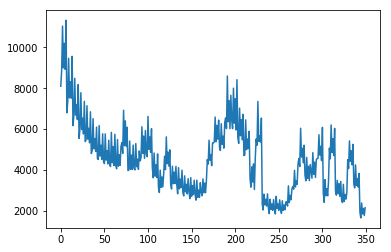

In [16]:
plt.plot(losses_val)

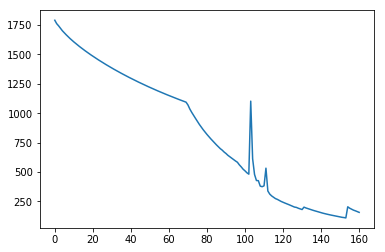

In [43]:
plt.plot(losses_val)

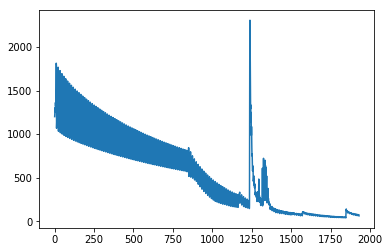

In [44]:
plt.plot(losses_train)

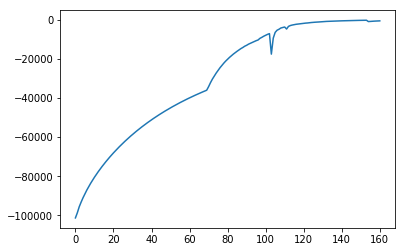

In [45]:
plt.plot(EVs)

In [25]:
# torch.cuda.empty_cache()

show the results

# Problem (b)

In [42]:
# CHOOSE THE AUGMENTS IF NECESSARY
n_id = np.random.randint(0, n_neurons, [5])  #inspect several neurons
rep_num = 5  # reptitions of each neuron
iters = 200 # iterations for synthesis
lr = 0.01 # learing rate for synthesis
jitter = True # jitter the input for imitating the movement of the eyes

n_id_torch = torch.tensor(n_id.tolist(), dtype=torch.int64).to(device).repeat_interleave(rep_num).view(-1, 1)

def loss_TV(x):
    wd = x[:, :, 1:, :] - x[:, :, :-1, :]
    hd = x[:, :, :, 1:] - x[:, :, :, :-1]
    loss = (wd ** 2).mean([2]).sum() + (hd ** 2).mean([3]).sum()
    return loss

def jitter_image(img, max_pixels=19):
    sx, sy = np.random.randint(-max_pixels, max_pixels, size=2).tolist()
    img_shift = img.roll(sx, 3).roll(sy, 2)
    return img_shift

encoder.eval()
for param in encoder.parameters():
#     param.requires_grad_(False)
    param = param.detach()
    
init_images = np.random.uniform(0, 1, [len(n_id_torch), 1, 299, 299]).astype(np.float32)
x = torch.from_numpy(init_images)
x = x.to(device)


    
# PUT YOUR CODES HERE
""" 
    In each iteration, you can use jitter_image() function to jitter the input 
    image, and use transform predefined to apply standard imagnet preprocess
    
    Example:
        >>> x_jittered = jitter_image(x)
        >>> x_jittered = transform(x_jitter.repeat([1, 3, 1, 1]))
        ...
    
    In addition, it is better to normalize when updating the input image x
    
    Example:
        >>> grad = x.grad.detach()
        >>> grad /= grad.std([1, 2, 3], keepdim=True) + 1e-8
        >>> x = (x - lr * grad).clamp(0, 1).detach()    
"""
for i in range(iters):
    x_jittered = jitter_image(x)
    x_jittered = transform(x_jitter.repeat([1, 3, 1, 1]))
    fmap = alexnet(x_jittered,layer = insp_layer)
    out = encoder(fmap)
    l_res = -torch.sum(out[:,n_id_torch])
    l_tv = loss_TV(x)
    (l_res + l_tv).backward()
    grad = x.grad.detach()
    grad /= grad.std([1, 2, 3], keepdim=True) + 1e-8
    x = (x - lr * grad).clamp(0, 1).detach()

plt.imshow(x[0,0])

AttributeError: 'Tensor' object has no attribute 'repeat_interleave'

In [ ]:
init_images = np.random.uniform(0, 1, [len(n_id_torch), 1, 299, 299]).astype(np.float32)
x = torch.from_numpy(init_images)
x = x.to(device)


    
# PUT YOUR CODES HERE
""" 
    In each iteration, you can use jitter_image() function to jitter the input 
    image, and use transform predefined to apply standard imagnet preprocess
    
    Example:
        >>> x_jittered = jitter_image(x)
        >>> x_jittered = transform(x_jitter.repeat([1, 3, 1, 1]))
        ...
    
    In addition, it is better to normalize when updating the input image x
    
    Example:
        >>> grad = x.grad.detach()
        >>> grad /= grad.std([1, 2, 3], keepdim=True) + 1e-8
        >>> x = (x - lr * grad).clamp(0, 1).detach()    
"""
for i in range(iters):
    x_jittered = jitter_image(x)
    x_jittered = transform(x_jitter.repeat([1, 3, 1, 1]))
    fmap = alexnet(x_jittered,layer = insp_layer)
    out = encoder(fmap)
    l_res = -torch.sum(out[:,n_id_torch])
    l_tv = loss_TV(x)
    (l_res + l_tv).backward()
    grad = x.grad.detach()
    grad /= grad.std([1, 2, 3], keepdim=True) + 1e-8
    x = (x - lr * grad).clamp(0, 1).detach()
    break